<h1>Рекомендация тарифов<span class="tocSkip"></span></h1>

# 1 Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана.

Необходимо построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Необходимо проверить *accuracy* на тестовой выборке.

## 1.1 Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
<br>сalls — количество звонков,
<br>minutes — суммарная длительность звонков в минутах,
<br>messages — количество sms-сообщений,
<br>mb_used — израсходованный интернет-трафик в Мб,
<br>is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# 2 Изучение данных файла

In [ ]:
# загрузка библиотек
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
# Библиотеки для имплементации VIF
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
df = pd.read_csv('users_behavior.csv')
display(df.head())
df.info()

# Проверка на наличие дубликатов
print()
print('Кол-во дубликатов:')
display(df.duplicated().sum())

# Проверка на баланс в целевом ризнаке
print()
print('Кол-во 0 и 1 в датасете:')
print(df['is_ultra'].value_counts())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB

Кол-во дубликатов:


0


Кол-во 0 и 1 в датасете:
0    2229
1     985
Name: is_ultra, dtype: int64


,feature,VIF
0,calls,129.350246
1,minutes,126.448586
2,messages,2.184385
3,mb_used,4.380105


             calls   minutes  messages   mb_used
calls     1.000000  0.982083  0.177385  0.286442
minutes   0.982083  1.000000  0.173110  0.280967
messages  0.177385  0.173110  1.000000  0.195721
mb_used   0.286442  0.280967  0.195721  1.000000


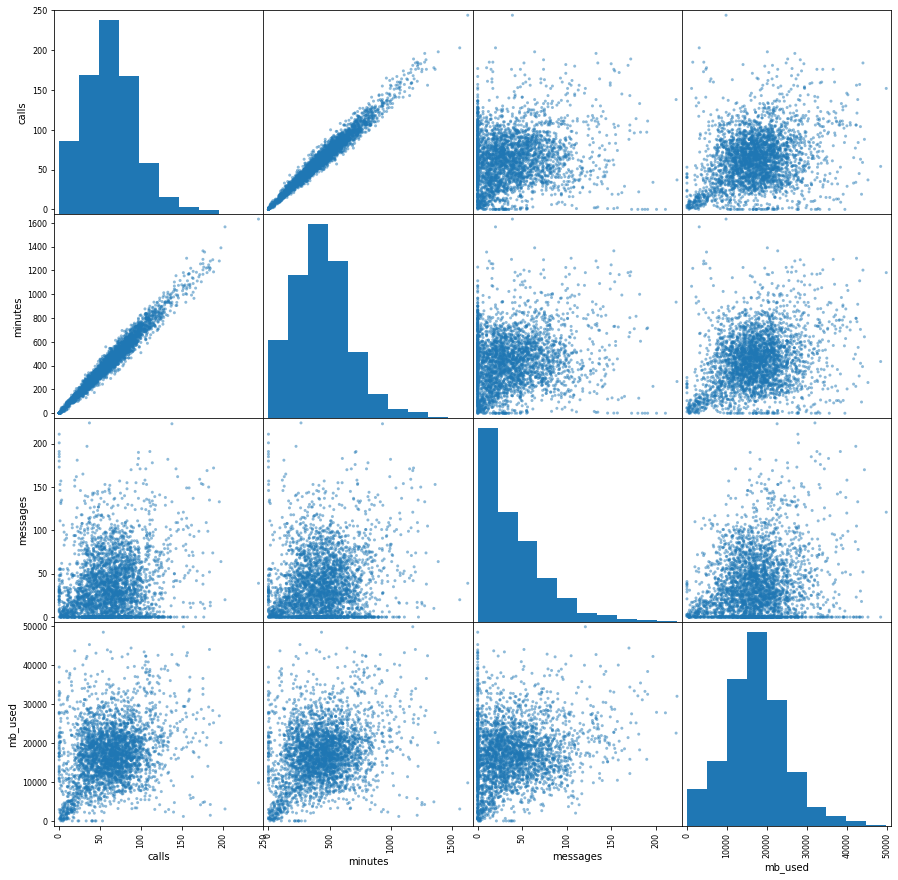

In [36]:
# Проверка на мультиколлинеарность с помощью VIF
features_df = df.drop('is_ultra',axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = features_df.columns
vif_data["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(len(features_df.columns))]
display(vif_data)

#Коллинеарность факторов
print(features_df.corr())
pd.plotting.scatter_matrix(features_df, figsize=(15, 15)) 
plt.show()

**Вывод:** Данные изучены. Так как нашей задачей является предсказание тарифов, 'is_ultra' - наш целевой признак. Все остальное - признаки.
1. Сначала был осмотрен сам датасет с помощью метода .head(), затем проверка типов данных, а также проверка на наличие пропусков с помощью .info()
2. Проверка на наличие дубликатов в строках - не найдено.
3. Проверка на баланс классов целевого признака ('is_ultra'). Видно, что пользователей с тарифами "Смарт"(0), намного больше, чем с "Ультра". Такой дисбаланс классов может привести к тому, что модель будет "игнорировать" класс с наименьшим кол-вом значений и это может снизить точность модели.  Поэтому необходимо провести балансировку классов.
<br>

4. Проверка признаков на мультиколлинеарность с помощью VIF, корреляции и scatter plot. Результат показал, что есть очень высокая мультиколлинеарность между кол-вом звонков и их продолжительностью в минутах.

# 3 Разбивка данных и балансировка классов

In [37]:
985/3214

0.30647168637212197

### Вывод 3.1:

Для балансировки классов был выбран метод upsampling, т.к. создание дубликатов позволяет сохранить все данные в датасете (в отличие отметода downsampling). В итоге, классы в целевом признаке были сбалансированы в соотношении 1:1

In [38]:
# Определение целевого признака
features = df.drop(['is_ultra','calls'], axis=1)
target = df['is_ultra']


# Разбивка данных на тренировочную, тестовую и валидационную выборки
train_features, test_features, train_target, test_target = train_test_split(features, target,test_size=0.2,train_size=0.8,random_state=12345)
train_features, valid_features, train_target, valid_target = train_test_split(train_features,train_target,test_size = 0.25,train_size =0.75,random_state=12345)

print()
print('Кол-во 0 и 1 в train_target sample:')
display(train_target.value_counts())


Кол-во 0 и 1 в train_target sample:


0    1339
1     589
Name: is_ultra, dtype: int64

### Вывод 3.2 
Используя сбалансированный дасет, разбили данные на 3 выборки: тренировочную, тестовую и валидационную в соотношении 60:20:20. 

# 4 Исследование моделей

## 4.1 Дерево Решений

In [39]:
valid_model = None
best_depth = 0
best_result = 0
for depth in range(1, 31, 2):
    DecisionTree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth).fit(train_features, train_target)
    valid_predictions = DecisionTree_model.predict(valid_features)
    valid = accuracy_score(valid_target, valid_predictions)
    if valid > best_result:
            valid_model = DecisionTree_model
            best_result = valid
            best_depth = depth

print("Accuracy модели на валидационной выборке:", best_result, "Глубина:", best_depth)

Accuracy модели на валидационной выборке: 0.7682737169517885 Глубина: 7


### Вывод 4.1 
Первой моделью к рассмотрению была выбрана модель дерева решений. Глубина выбиралась эксперементальным методом через цикл от 1 до 31 с шагом в 2. Шаг был установлен на 2, чтобы сохранять скорость работы кода и чтобы в то же время перебрать максимальное количество вариантов, выбрав наиболее оптимальный.

Среди параметров и гиперпараметров были выбраны random_state (случайное состояние) и глубина (max_depth).


Рассмотрим другие модели:

## 4.2 Случайный лес

In [40]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for estimator in range(1, 31, 2):
    for depth in range(1, 31, 2):
        RanForest_model = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth).fit(train_features, train_target)
        result = RanForest_model.score(valid_features, valid_target) 
        if result > best_result:
            best_model = RanForest_model
            best_result = result
            best_est = estimator
            best_depth = depth

print("Accuracy модели на валидационной выборке:", best_result,"Кол-во деревьев:", best_est, "Глубина:", best_depth)

Accuracy модели на валидационной выборке: 0.7978227060653188 Кол-во деревьев: 15 Глубина: 23


### Вывод 4.2
Следующей моделью на рассмотрение была выбрала модель Случайного леса. Подобно модели Дерева Решений, значения estimators и глубины были выбраны с помощью цикла.

Среди параметров и гиперпараметров были выбраны random_state (случайное состояние), количество оценщиков (n_estimators), и глубина (max_depth).



## 4.3 Логистическая регрессия

In [41]:
best_result = 0
LogisticReg_model = LogisticRegression(random_state=12345,solver='liblinear').fit(train_features, train_target)
reg_result = LogisticReg_model.score(valid_features, valid_target)
if reg_result > best_result:
    best_model = LogisticReg_model
    best_result = reg_result

print("Accuracy модели на валидационной выборке:", best_result,"Кол-во деревьев:")

Accuracy модели на валидационной выборке: 0.7013996889580093 Кол-во деревьев:


### Вывод 4.3
Третьей моделью к анализу была выбрана логистическая регрессия. Логистическая регрессия показала наихудшие результаты из исследованных 3х моделей с accuracy только в 68%.

*Прим: solver='liblinear' указан как решение проблемы на выдаваемые программой ошибки. Я не до конца понимаю, что этот параметр делает)

# 5 Проверка моделей на тестовой выборке

## 5.1 Дерево Решений

In [42]:
DecisionTree_model = DecisionTreeClassifier(random_state=12345, max_depth=21).fit(train_features, train_target)
test_predictions = DecisionTree_model.predict(test_features)
test_1 = accuracy_score(test_target, test_predictions)

print("Accuracy модели на тестовой выборке:", test_1)

Accuracy модели на тестовой выборке: 0.7325038880248833


### Вывод 5.1
Проверяем модель на тестовой выборке, которая изначально была отделена от датасета. 


## 5.2 Случайный лес

In [43]:
RanForest_model = RandomForestClassifier(random_state=12345, n_estimators=27, max_depth=29).fit(train_features, train_target)
test_2 = RanForest_model.score(test_features, test_target)

print("Accuracy модели на тестовой выборке:", test_2)

Accuracy модели на тестовой выборке: 0.7884914463452566


### Вывод 5.2


## 5.3 Логистическая регрессия

In [44]:
LogisticReg_model = LogisticRegression(random_state=12345,solver='liblinear').fit(train_features, train_target)
test_3 = LogisticReg_model.score(test_features, test_target)

print("Accuracy модели на тестовой выборке:", test_3)

Accuracy модели на тестовой выборке: 0.7013996889580093


### Вывод 5.3


Возьмем модель с наилучшим значением accuracy и попробуем улучшить результаты, подкрутив гиперпараметры.

In [45]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for estimator in range(1, 31, 2):
    for depth in range(1, 31, 2):
        RanForest_model = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth).fit(train_features, train_target)
        result = RanForest_model.score(test_features, test_target) 
        if result > best_result:
            best_model = RanForest_model
            best_result = result
            best_est = estimator
            best_depth = depth

print("Accuracy модели на валидационной выборке:", best_result,"Кол-во деревьев:", best_est, "Глубина:", best_depth)

Accuracy модели на валидационной выборке: 0.80248833592535 Кол-во деревьев: 5 Глубина: 7


#### Вывод 5.3.1

На той же тестовой выборке, создав цикл, модель была приведена к 87% accuracy, что является более высоким результатом, но все еще на 1% ниже, чем на валидационной выборке.

Модель "Случайный лес" показала себя наиболее точной моделью, поэтому выбирается именно она.

# 6 Проверка модели на адекватность

In [46]:
unsampled_features = df.drop('is_ultra', axis=1)
unsampled_target = df.is_ultra

RanForest_model_unsampled = RandomForestClassifier(random_state=12345,n_estimators=27, max_depth=29).fit(unsampled_features, unsampled_target)

predicted = RanForest_model_unsampled.predict(unsampled_features)
 
# Проверка
print( accuracy_score(unsampled_target, predicted) )

0.9965774735532047


### Вывод 
Необходимо оценить статистические данные на вменяемость, чтобы проверить действительно ли работает выбранная нами модель на всем датасете.

Accuracy на "сыром" датасете, при использовании модели "Случайный лес" и гиперпараметров, которые привели к наилучшим результатам, равняется 0.99, что максимально близко к единице. Модель прошла feasibility test (тест на адекватность)

# 7 Общий Вывод

Выводы по пройденым этапам в проекте:
1. Открыли, проанализировалли данные, проверив на дубликаты и дисбананс классов в целевом признаке.
2. Сбалансировали классы в целевом признаке, создав новый "сбалансированный" датасет, по которому разбили данные на 3 выборки
3. Исследовали 3 модели "Дерево решений", "Случайный лес" и "Логистическая Регрессия". Лучший результат accuracy (0.88) показала модель "Случайный лес".
4. Проверили модели на заранее отделенной части датасета - тестовой выборке. "Случайный лес" по-прежнему показала лучшие результаты  accuracy 0.84, но заниженный результат указывал на возможное "переобучение" модели. На той же тестовой выборке, создав цикл, модель была приведена к 87% accuracy, что является более высоким результатом, но все еще на 1% ниже, чем на валидационной выборке.
5. Модель случайный лес была выбрана для провери на адекватность. На всем датасете, модель показала 99% accuracy.

По заданию, необходимо было построить модель для задачи классификации, которая выберет подходящий тариф. Модель выбрана, это модель -  "Случайный лес", лучшая оценка - accuracy = 0.8 (80%) с максимальной глубиной = 29 и счетчиком значений = 27.

Рекомендации: 
1. 3х базовых моделей и метрики accuracy может быть недостаточно для того, чтобы определить наиболее оптимальную модель. Стоить проверить другие метрики или другие модели, чтобы убедиться в результатах.